In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
import tifffile
import os
import numpy as np
from matplotlib import pyplot as plt

In [6]:
path_img = Path('./data/three_band/')
path_lbl = Path('./data/masks/1/')

In [7]:
fnames = get_image_files(os.path.join(path_img, 'train'))
fnames[:3]

[PosixPath('data/three_band/train/6110_3_1.tif'),
 PosixPath('data/three_band/train/6150_2_3.tif'),
 PosixPath('data/three_band/train/6010_4_2.tif')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/masks/1/6010_1_2_M.tif'),
 PosixPath('data/masks/1/6090_2_0_M.tif'),
 PosixPath('data/masks/1/6060_2_3_M.tif')]

In [9]:
def open_tiff(fn: pathlib.PosixPath) -> Image:
        img = tifffile.imread(str(fn))
        img_t = torch.from_numpy(img.astype(np.float32, copy=False))
        img_t.div_(2047)
        return Image(img_t)

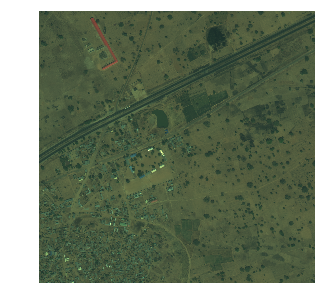

In [88]:
img_f = fnames[0]
img = open_tiff(img_f)
img.show(figsize=(5,5))

torch.Size([1, 3348, 3396])
torch.Size([1, 3348, 3403])
torch.Size([1, 3345, 3396])
torch.Size([1, 3349, 3391])
torch.Size([1, 3348, 3396])
torch.Size([1, 3349, 3389])
torch.Size([1, 3349, 3389])
torch.Size([1, 3349, 3391])
torch.Size([1, 3349, 3393])
torch.Size([1, 3349, 3393])
torch.Size([1, 3348, 3403])
torch.Size([1, 3349, 3391])
torch.Size([1, 3346, 3387])
torch.Size([1, 3348, 3396])
torch.Size([1, 3349, 3391])
torch.Size([1, 3348, 3403])
torch.Size([1, 3348, 3396])
torch.Size([1, 3348, 3396])
torch.Size([1, 3349, 3391])
torch.Size([1, 3350, 3338])
torch.Size([1, 3345, 3393])
torch.Size([1, 3349, 3391])
torch.Size([1, 3345, 3393])
torch.Size([1, 3348, 3403])
torch.Size([1, 3349, 3396])


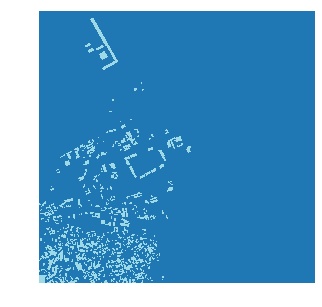

In [96]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_M{x.suffix}'

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([3348, 3396]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]]]))

In [13]:
class SegmentationTiffList(SegmentationItemList):
    
    def open(self, fn: pathlib.PosixPath) -> Image: 
        return open_tiff(fn)

In [89]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=10., max_warp=0.)

src = (SegmentationTiffList
       .from_folder(path_img)
       .split_by_folder(train='train', valid='train')
       .label_from_func(get_y_fn, classes=['no_buildings', 'buildings']))
       
data = (src
        .transform(tfms, size=(128, 130), tfm_y=True)
        .databunch(bs=1)
        .normalize(imagenet_stats))

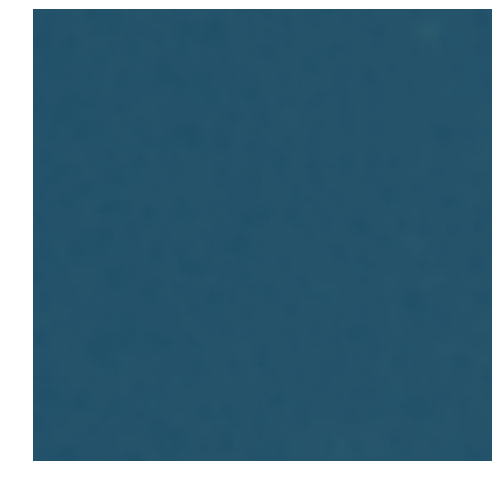

In [90]:
data.show_batch(rows=2, figsize=(7, 7))

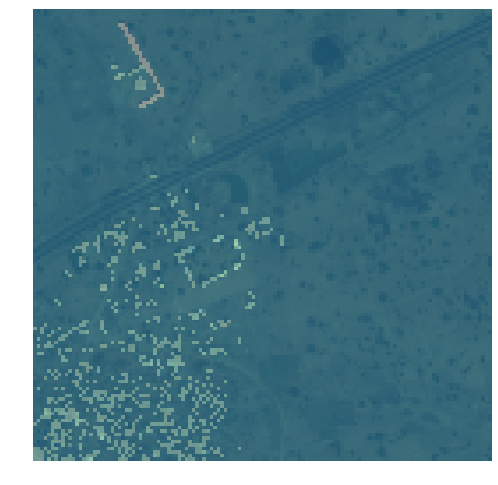

In [91]:
data.show_batch(rows=2, figsize=(7, 7), ds_type=DatasetType.Valid)

In [92]:
input_data, labels = data.one_batch()
print('Input data: ', input_data.shape)
print('Labels: ', labels.shape)

Input data:  torch.Size([1, 3, 128, 130])
Labels:  torch.Size([1, 1, 128, 130])


In [93]:
jaccard_index = partial(dice, iou=True)

In [94]:
learn = unet_learner(data, models.resnet34, metrics=jaccard_index, wd=1e-4)

In [97]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 65]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 65]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 65]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 33]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 33]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 33]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 33]         0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


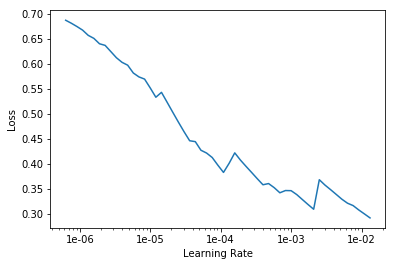

In [95]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 5e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-5

In [ ]:
learn.fit_one_cycle(5, slice(lr/10, lr))

In [ ]:
learn.show_results()